# Business Problem

#### Objetivo do problema

-- Previsão do primeiro destino que um novo usuario irá escolher

#### Porque?

##### Qual tipo de modelo de negócio do AirBNB?

-- MarketPlace (Conecta pessoas que oferecem acomodações, com pessoas que estão procurando acomodação).

##### Oferta (Pessoas oferecendo acomodação)

-- Tamanho do portfólio
-- Diversidade / densidade de portfólio
-- Preço médio

##### Demanda (Pessoas procurando acomodação)

-- Número de usuarios
-- LTV (Lifitime Value)
-- CAC (Client Acquisition Cost)
-- Cross Revenue ( FEE * Numero Cliente) - CAC

##### Proposta da Solução

-- Modelo de predição do primeiro destino de um novo usuario

##### Tipos de formatos para entrega do projeto

-- Predições salva em tabela do banco de dados.
-- API: Input: Usuario e suas caracteristicas / Output: Usuarios e suas caracteristicas com as predições do destino.

|Feature Name| Information|
|----------------|:---------------:|
|id:                         |ID do Usuario
|date_account_created:       |Data da Criação da Conta
|timestamp_first_active:     |Data do primeira acesso, note que pode ser anterior à data de criação da conta ou à data da primeira reserva porque um utilizador pode pesquisar antes de se inscrever
|date_first_booking:         |data da primeira reserva
|gender                      |Sexo
|age                         |Idade 
|signup_method               |Metodo de inscrição
|signup_flow:                |fluxo de inscrição: a página de onde um utilizador veio para se inscrever
|language:                   |Preferencia linguistica internacional
|affiliate_channel:          |canal afiliado: que tipo de marketing pago
|affiliate_provider:         |fornecedor afiliado: onde o marketing é, por exemplo, google, craigslist, outro
|first_affiliate_tracked:    |primeira afiliação rastreada: qual foi o primeiro marketing com que o utilizador interagiu antes da inscrição
|signup_app                  |Aplicativo de inscrição
|first_device_type           |Primeiro tipo de dispositivo
|first_browser               |Primeiro nagevagor
|country_destination:        |Destino do pai:Variavel alvo que deve prever

# 0.0 - Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as miss
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#Paths
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/data/'
path_model = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/airbnb_predict_booking_final/airnbn_predict_first-booking-/models/'

## Functions

In [3]:
def drescriptive_statistical (df):

    num_atributes = df.copy()
    #Central Tendency - mean - median
    ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

    #Dispersion - STD, min, max, range, sken, Kurtosis
    d1 = pd.DataFrame(num_atributes.apply(np.std)).T
    d2 = pd.DataFrame(num_atributes.apply(min)).T
    d3 = pd.DataFrame(num_atributes.apply(max)).T
    d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min() )).T
    d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew() )).T
    d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis() )).T

    #Concatenate

    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()


#Function Calculates cramer V
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - ( k - 1 ) * ( r - 1) / (n - 1))
    kcorr = k - (k - 1) **2/(n - 1) 
    rcorr = r - (r - 1) **2/(n - 1)
    
    return np.sqrt( (chi2corr / n) / (min(kcorr -1, rcorr -1) ) )

## Loading Data

## Data Sessions

In [4]:
session = pd.read_csv(path_data+'sessions.csv')

In [5]:
session.head(1).T

,0
user_id,d1mm9tcy42
action,lookup
action_type,NaN
action_detail,NaN
device_type,Windows Desktop
secs_elapsed,319.0


In [6]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [7]:
session.user_id.value_counts().head()
#Ja podemos notar que temos repetição para o mesmo user id

mxqbh3ykxl    2722
0hjoc5q8nf    2644
mjbl6rrj52    2476
l5lgm3w5pc    2424
wg9413iaux    2362
Name: user_id, dtype: int64

# 1.0 Data Description and Cleaning

In [8]:
#Data Dimensions

print('Number of Rows: {}'.format(session.shape[0]))
print('Number of Columns: {}'.format(session.shape[1]))

Number of Rows: 10567737
Number of Columns: 6


In [9]:
# Data Types

session.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## Check NA Session

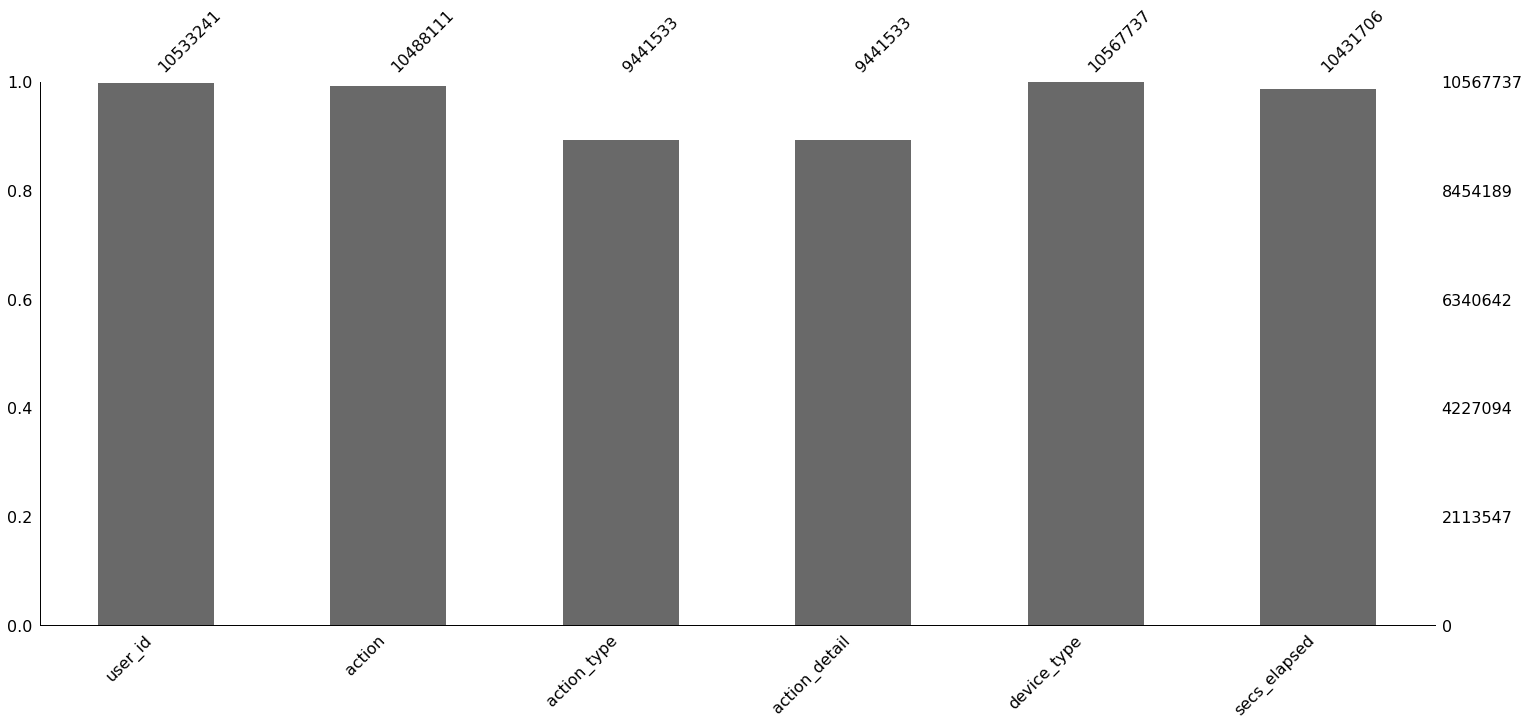

In [10]:
miss.bar(session)
sns.despine()

In [11]:
#Para os NAs estou assumindo a alteração pela moda de cada coluna exceto para a coluna secs_elapsed, nesta colo o valor 0

session['action'].fillna(session['action'].mode()[0], inplace=True)
session['action_type'].fillna(session['action_type'].mode()[0], inplace=True)
session['action_detail'].fillna(session['action_detail'].mode()[0], inplace=True)
session['device_type'].fillna(session['device_type'].mode()[0], inplace=True)
session['secs_elapsed'].fillna(0, inplace=True)

#Replace no espaço com _ no device_type
session.device_type = session.device_type.str.replace(' ', '_')

In [12]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows_Desktop,67753.0
2,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows_Desktop,22141.0
4,d1mm9tcy42,lookup,view,view_search_results,Windows_Desktop,435.0


In [13]:
#Removendo valor nulo do user_id

session = session[pd.isnull(session.user_id) == False]

In [14]:
session.shape

(10533241, 6)

In [15]:
#Adicionando espaço para conseguir mesclar em uma linha

session['action'] = [' ' + i + ' ' for i in session['action']]
session['action_type'] = [' ' + i + ' ' for i in session['action_type']]
session['action_detail'] = [' ' + i + ' ' for i in session['action_detail']]

In [16]:
user_id = list(set(session['user_id'].values))
len(user_id)

135483

In [17]:
#Pegando valor medio de ucada usuario especifico

sec_e = session.groupby('user_id', sort=False,)[['secs_elapsed']].mean()
sec_e.count()

secs_elapsed    135483
dtype: int64

In [18]:
#Gerando nova sessão para cada ID com apenas uma linha

action = session.groupby('user_id', sort=False)[['action']].sum()
action_type = session.groupby('user_id', sort=False)[['action_type']].sum()
action_detail = session.groupby('user_id', sort=False)[['action_detail']].sum()

In [19]:
#Criando novo Data Frame com as novas sessoes usando o agrupamento 

new_session = pd.DataFrame(user_id, columns=['user_id'])
new_session['action'] = action['action'].values
new_session['action_type'] = action_type['action_type'].values
new_session['action_detail'] = action_detail['action_detail'].values
new_session['secs_elapsed'] = sec_e['secs_elapsed'].values

new_session

,user_id,action,action_type,action_detail,secs_elapsed
0,qhlin1m4au,lookup search_results lookup search_result...,view click view click view click view ...,view_search_results view_search_results vie...,26988.417323
1,rrejislmu8,dashboard create confirm_email show show_...,view submit click view data view data ...,dashboard create_user confirm_email_link p...,23093.555556
2,rabdqsbhrg,verify create show pending requested hea...,-unknown- submit message_post booking_requ...,-unknown- create_user message_post pending...,70965.250000
3,gsh4cx89rl,lookup show search_results search_results ...,view view click click view view click ...,view_search_results p3 view_search_results ...,24704.605263
4,83iuuz3dgh,campaigns active create notifications lis...,-unknown- -unknown- -unknown- -unknown- -...,-unknown- -unknown- -unknown- -unknown- -...,319.375000
...,...,...,...,...,...
135478,dhw16of0rw,confirm_email authenticate index header_us...,click submit view data submit submit da...,confirm_email_link login your_listings hea...,27249.806452
135479,0bai1bqlg5,index campaigns collections active show ...,view view view -unknown- view view view...,view_reservations view_search_results user_...,2580.900000
135480,pxqkaulydt,index my index search_results search_resu...,view view view click click click click ...,view_search_results user_wishlists user_wis...,10555.089744
135481,x5wv28tbuy,show update create personalize header_use...,view submit -unknown- data data submit ...,view_search_results update_listing -unknown...,23471.200000


In [20]:
new_session.shape

(135483, 5)

## Data Train_users

In [21]:
train = pd.read_csv(path_data+'train_users_2.csv')

In [22]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [23]:
#Data Dimensions

print('Number of Rows: {}'.format(train.shape[0]))
print('Number of Columns: {}'.format(train.shape[1]))

Number of Rows: 213451
Number of Columns: 16


In [24]:
#Renomeando o ID
train.rename(columns={'id': 'user_id'}, inplace=True)
train.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF


## Check NA

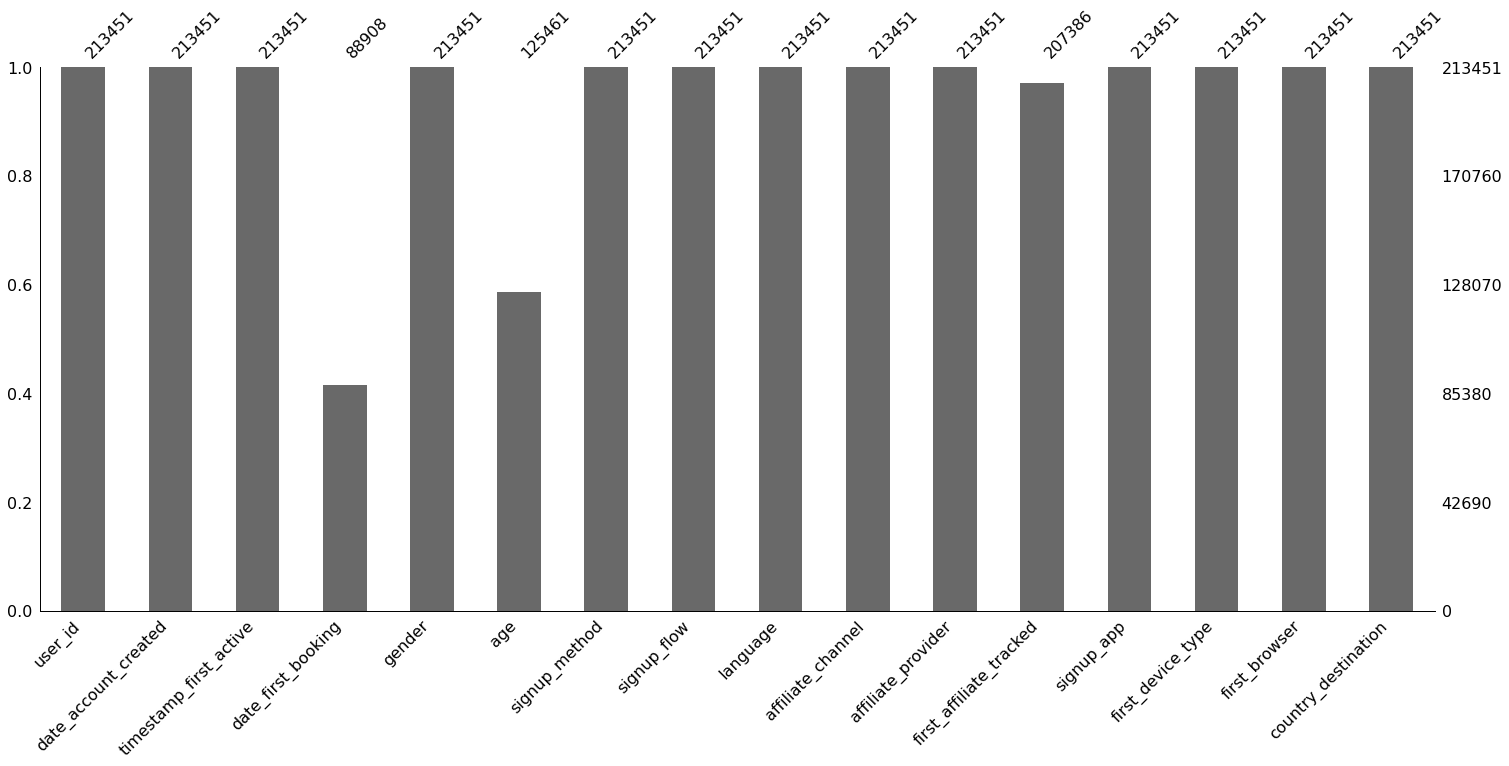

In [25]:
miss.bar(train)
sns.despine()

In [26]:
train.isna().sum() / len(train)

user_id                    0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

#### Date_first_booking

In [27]:
# Temos Quase 60% dos dados faltantes nessa coluna, os dados faltantes representa apenas uma classe da variavel resposta (Sem destino definido)
# Para preservar os dados e se estivesse trabalhando na AIRBNB colocaria a data atual, pois neste caso todos os dias os dados seriam atualizados para o dia atual.
# Quando o cliente entrou no site até hoje teria x dias que ele ainda não fez o book. Dessa forma seria calculado essa quantidade de dias como features.
# Como esses dados não estão atualizados, estou pegando a ultima data que temos de informação na coluna e adicionando para os dados faltantes 

# Tratamento dos NAs da coluna date_first_booking
aux = train[train['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)

#Transformando os NAs na data maxima do date_first_booking
date_first_booking_max = pd.to_datetime(train['date_first_booking']).max().strftime('%Y-%m-%d')
train.date_first_booking = train['date_first_booking'].fillna(date_first_booking_max)


### Age

In [28]:
train.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [29]:
aux_age = train[train['age'].isna()]
print(aux_age['country_destination'].value_counts(normalize=True))
#Existe uma distribuição entre a idade NAs em relação a classe procurada.

#Estarei adicionado a media da idade para idade acima de 95 e menor que 16. Assumindo que pessoas acima de 95 anos dificilmente conseguem realizar reserva e menores de 16
#anos tambem.

train.loc[train['age'] > 120, 'age'] = np.nan
train.loc[train['age'] < 16, 'age'] = np.nan

train.loc[train['age'].isnull(), 'age'] = train.age.median()


NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64


<AxesSubplot:xlabel='age', ylabel='Density'>

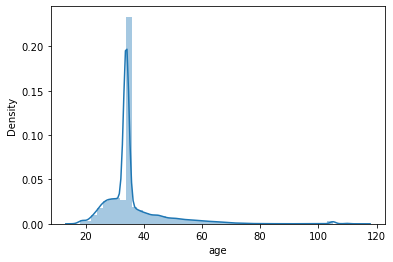

In [30]:
sns.distplot(train.age)

### First_affiliate_tracked

In [31]:
#Os NAs dessa coluna representa apenas 2% do total dos dados, neste caso estarei excluindo todos os NAs.

train = train[~train['first_affiliate_tracked'].isna()]

In [32]:
train.isna().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

## Data Types

In [33]:
train.dtypes

user_id                     object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### Tratamento nos tipos das colunas

In [34]:
train.head(1)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,2015-06-29,-unknown-,34.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF


In [35]:
#date_acount_created
train.date_account_created = pd.to_datetime(train.date_account_created)

#Timestamp_first_active
train['timestamp_first_active'] = pd.to_datetime(train['timestamp_first_active'], format='%Y%m%d%H%M%S')
train.timestamp_first_active = pd.to_datetime(train.timestamp_first_active.dt.strftime('%Y-%m-%d'))

#data_first_booking
train.date_first_booking = pd.to_datetime(train.date_first_booking)

#age
train.age = train.age.astype(int)


#Limpeza e ajustes nos dados

train['first_device_type'] = [s.replace(' ', '_') for s in train.first_device_type]
train['first_device_type'] = [s.replace('/', '_') for s in train.first_device_type]
train['first_device_type'] = [s.replace('(', '') for s in train.first_device_type]
train['first_device_type'] = [s.replace(')', '') for s in train.first_device_type]
train['affiliate_channel'] = [s.replace('-', '_') for s in train.affiliate_channel]
train['affiliate_provider']= [s.replace('-', '_') for s in train.affiliate_provider]
train['first_browser']     = [s.replace('-', '') for s in train.first_browser]
train['first_browser']     = [s.replace(' ', '_') for s in train.first_browser]
train['first_browser']     = [s.replace('.', '_') for s in train.first_browser]
train['gender']            = [s.replace('-', '') for s in train.gender]

In [36]:
train.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [37]:
train.head(1)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19,2015-06-29,unknown,34,facebook,0,en,direct,direct,untracked,Web,Mac_Desktop,Chrome,NDF


## Dataset Train_user Final

In [38]:
#Juntando dataset session com o dataset treino.
new_train = train.set_index('user_id').join(new_session.set_index('user_id'), how='inner', on='user_id').reset_index()
new_train.head(1)

#Data Dimensions

print('Number of Rows: {}'.format(new_train.shape[0]))
print('Number of Columns: {}'.format(new_train.shape[1]))

Number of Rows: 73513
Number of Columns: 20


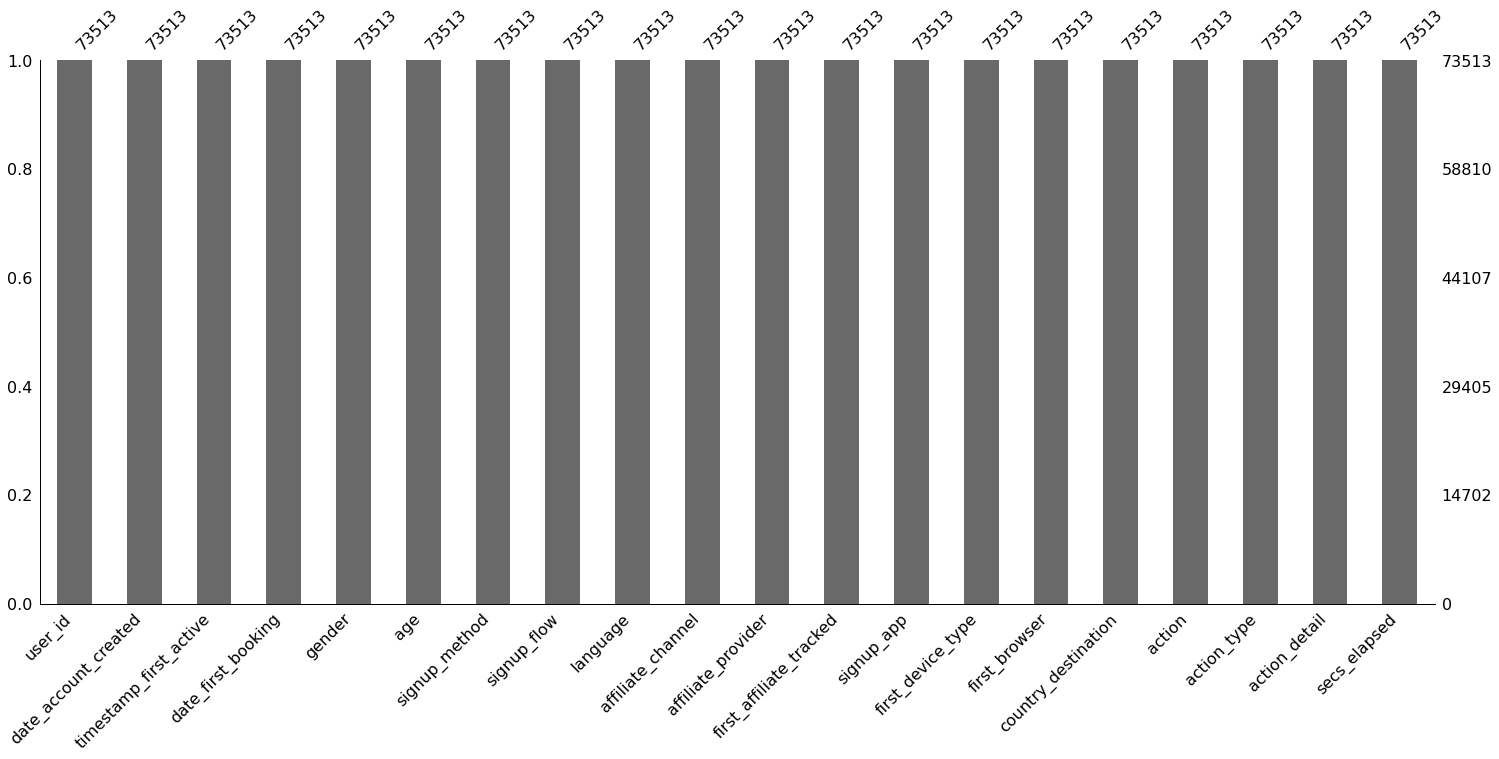

In [39]:
miss.bar(new_train)
sns.despine()

In [40]:
new_train.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
action                             object
action_type                        object
action_detail                      object
secs_elapsed                      float64
dtype: object

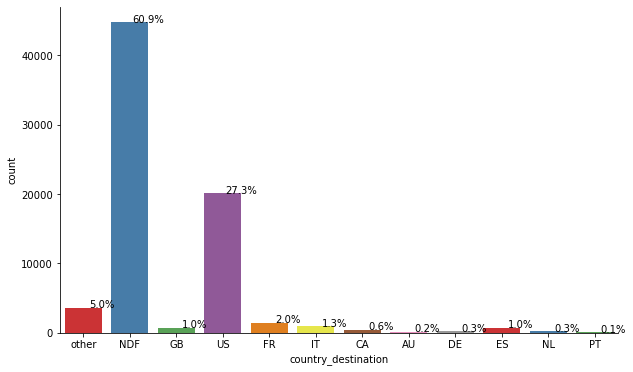

In [41]:
#Chack Balanced Data

plt.figure(figsize = (10, 6))
ax = sns.countplot(x='country_destination', data=new_train, palette='Set1')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / new_train.shape[0])
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
sns.despine()


## Data test_users

In [43]:
data = pd.read_csv(path_data+'test_users.csv')
data.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [44]:
#Data Dimensions
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Columns: {}'.format(data.shape[1]))

Number of Rows: 62096
Number of Columns: 15


In [45]:
#Renomeando o ID
data.rename(columns={'id': 'user_id'}, inplace=True)
data.head(2)

,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


## Check NA

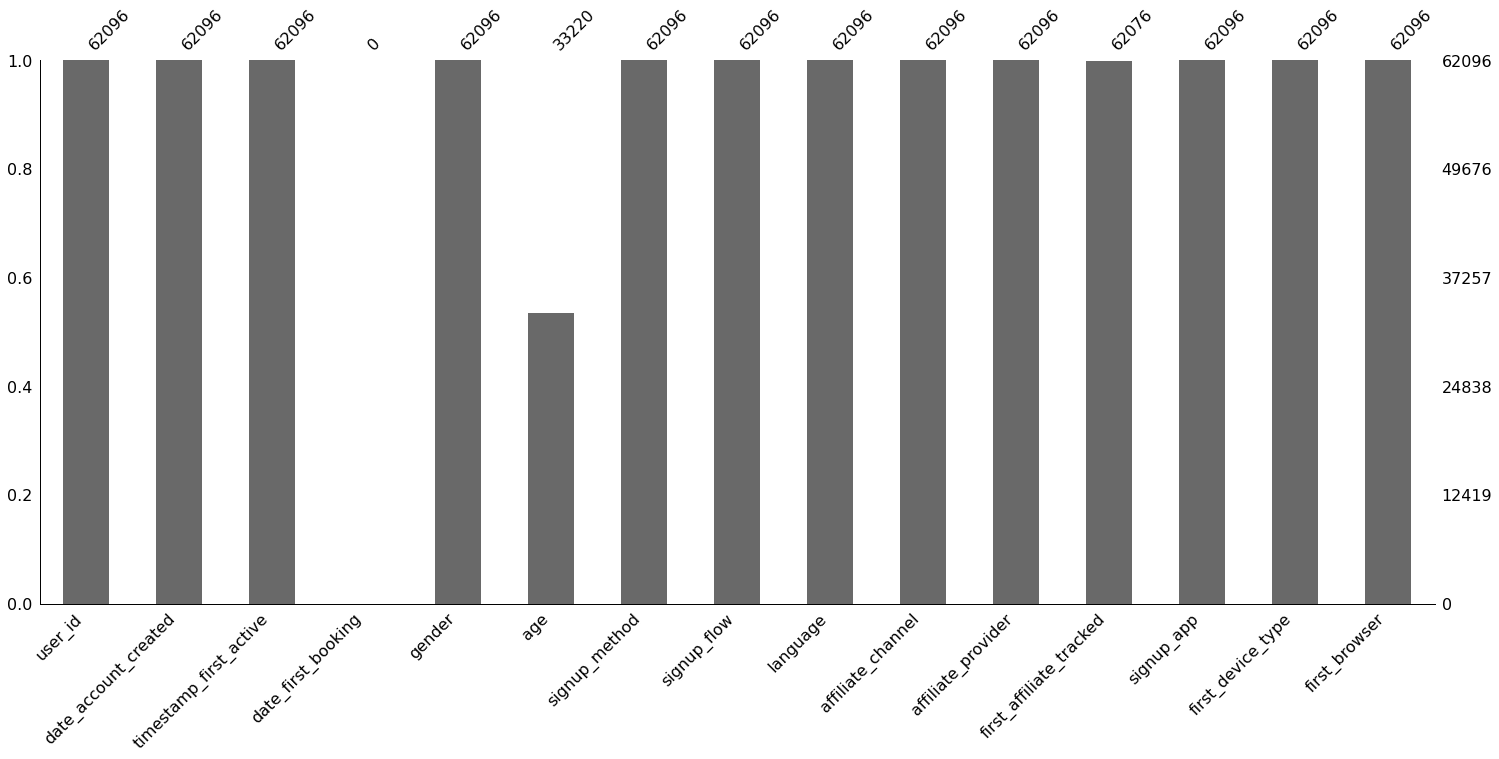

In [46]:
miss.bar(data)
sns.despine()

In [47]:
data.isna().sum() / len(data)

user_id                    0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         1.000000
gender                     0.000000
age                        0.465022
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.000322
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
dtype: float64

#### Date_first_booking

In [48]:
#Nesta coluna temos 100% NAs, pois como são dados de teste não teremos nenhum cliente que ja
#tenha feito o primeiro book.
#Neste caso iremos excluir essa coluna.

data = data.drop('date_first_booking', axis=1)

### Age

In [49]:
data.age.describe()

count    33220.000000
mean        37.616677
std         74.440647
min          1.000000
25%         26.000000
50%         31.000000
75%         40.000000
max       2002.000000
Name: age, dtype: float64

In [50]:
aux1_age = data[data['age'].isna()]

#Estarei adicionado a media da idade para idade acima de 95 e menor que 16. Assumindo que pessoas acima de 95 anos dificilmente conseguem realizar reserva e menores de 16
#anos tambem.

data.loc[data['age'] > 120, 'age'] = np.nan
data.loc[data['age'] < 16, 'age'] = np.nan

data.loc[data['age'].isnull(), 'age'] = train.age.median()


<AxesSubplot:xlabel='age', ylabel='Density'>

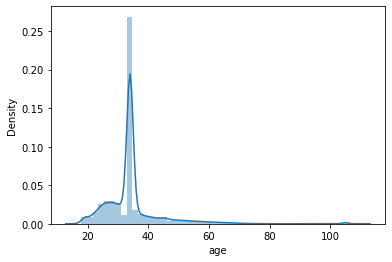

In [51]:
sns.distplot(data.age)

### First_affiliate_tracked

In [52]:
#Os NAs dessa coluna representa apenas 2% do total dos dados, neste caso estarei excluindo todos os NAs.

data = data[~data['first_affiliate_tracked'].isna()]

In [53]:
data.isna().sum()

user_id                    0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
dtype: int64

In [54]:
data.dtypes

user_id                     object
date_account_created        object
timestamp_first_active       int64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
dtype: object

### Tratamento nos tipos das colunas

In [55]:
data.head(1)

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari


In [56]:
#data_acount_created
data.date_account_created = pd.to_datetime(data.date_account_created)

#timestamp_first_active
data['timestamp_first_active'] = pd.to_datetime(data['timestamp_first_active'], format='%Y%m%d%H%M%S')
data.timestamp_first_active = pd.to_datetime(data.timestamp_first_active.dt.strftime('%Y-%m-%d'))

#data_first_booking
data.age = data.age.astype(int)

#Tratamento e ajustes nos dados
data['first_device_type'] = [s.replace(' ', '_') for s in data.first_device_type]
data['first_device_type'] = [s.replace('/', '_') for s in data.first_device_type]
data['first_device_type'] = [s.replace('(', '') for s in  data.first_device_type]
data['first_device_type'] = [s.replace(')', '') for s in  data.first_device_type]
data['affiliate_channel'] = [s.replace('-', '_') for s in data.affiliate_channel]
data['affiliate_provider']= [s.replace('-', '_') for s in data.affiliate_provider]
data['first_browser']     = [s.replace('-', '') for s in  data.first_browser]
data['first_browser']     = [s.replace(' ', '_') for s in data.first_browser]
data['first_browser']     = [s.replace('.', '_') for s in data.first_browser]
data['gender']            = [s.replace('-', '') for s in  data.gender]

In [57]:
data.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
dtype: object

In [58]:
data.head(1)

,user_id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile_Safari


## Dataset Test_user Final

In [59]:
#Juntando dataset session com o dataset treino.

new_test = data.set_index('user_id').join(new_session.set_index('user_id'), how='inner', on='user_id').reset_index()
new_test.head(1)

#Data Dimensions

print('Number of Rows: {}'.format(new_test.shape[0]))
print('Number of Columns: {}'.format(new_test.shape[1]))

Number of Rows: 61662
Number of Columns: 18


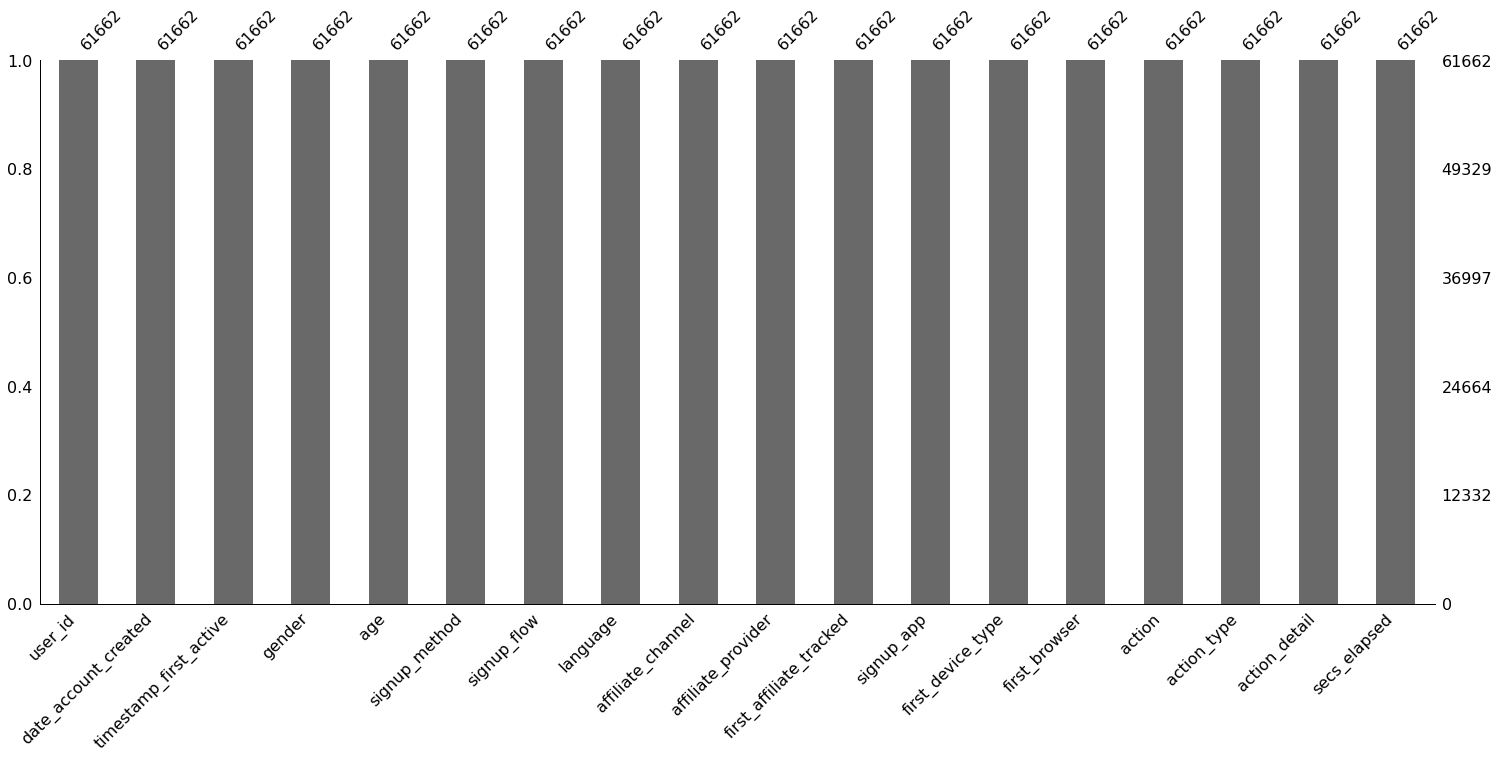

In [60]:
miss.bar(new_test)
sns.despine()

In [61]:
new_test.dtypes

user_id                            object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
action                             object
action_type                        object
action_detail                      object
secs_elapsed                      float64
dtype: object

In [63]:
#Juntei o test com train para seguir com as analises e tratamento das colunas e no final faço a separação novamente.
df_final = pd.concat([new_train, new_test])

In [64]:
print('Number of Rows test: {}'.format(new_test.shape[0]))
print('Number of Columns test: {}'.format(new_test.shape[1]))
print('--------------------------------------------------')
print('Number of Rows train: {}'.format(new_train.shape[0]))
print('Number of Columns train: {}'.format(new_train.shape[1]))
print('------------------------------------------')
print('Number of Rows Join: {}'.format(df_final.shape[0]))
print('Number of Columns Join: {}'.format(df_final.shape[1]))

Number of Rows test: 61662
Number of Columns test: 18
--------------------------------------------------
Number of Rows train: 73513
Number of Columns train: 20
------------------------------------------
Number of Rows Join: 135175
Number of Columns Join: 20


# 2.0 Descriptive Statistics

In [65]:
num_atributes = df_final.select_dtypes(include=['int64', 'float64'])
cat_atributes = df_final.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 2.1 Numerical Atributes

In [66]:
drescriptive_statistical(num_atributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.000000,99.000000,34.878054,34.000000,10.253592,3.122752,15.961071
1,signup_flow,0.0,25.000000,25.000000,6.165800,0.000000,10.345016,1.153908,-0.580007
2,secs_elapsed,0.0,931358.666667,931358.666667,25906.128115,16050.100159,37538.002450,6.886404,83.004419


-- Anomalias detectado

--> signup_flow com registro zerado

--> secs_elapsed tambem com registro zerado

## 2.2 Cat Atributes

In [67]:
cat_atributes.describe().T

,count,unique,top,freq
user_id,135175,135175,d1mm9tcy42,1
gender,135175,4,unknown,71112
signup_method,135175,4,basic,99939
language,135175,25,en,129627
affiliate_channel,135175,8,direct,90147
affiliate_provider,135175,17,direct,90147
first_affiliate_tracked,135175,7,untracked,72751
signup_app,135175,4,Web,93970
first_device_type,135175,9,Mac_Desktop,44669
first_browser,135175,40,Chrome,37392


# 3.0 Feature Engineering

## Criação das Hipóteses

H01. Em todos os destinos, os usuarios levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativação

H02. Em todos os destino, os usuarios levam 3 dias, em media, para fazer o cadastro no site.

H03. O volume de reserva anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

H04. Usuarios do sexo Feminino fazem 10% mais reservas para paises fora do EUA.

H05. O canal de marketing google representa 40% das reservas para paises fora dos EUA

H06. O Destino dos USA representam mais de 20% em todos os canais

H07. A idade media das pessoas é de 35 anos em todos os destinos.

H08. A porcentagem de usuarios que usam o site n linhgua ingles-americanos para reservar acomodações em qualquer destino é maior que 90%.

H09. O Número de reserva do Airbnb é crescente ou decrescente ao longo dos anos

H10. O numero de reservas do Airbnb é crescente ao longo dos anos.

## Derivação de Novas Features

In [68]:
df_final.head(1).T

,0
user_id,d1mm9tcy42
date_account_created,2014-01-01 00:00:00
timestamp_first_active,2014-01-01 00:00:00
date_first_booking,2014-01-04 00:00:00
gender,MALE
age,62
signup_method,basic
signup_flow,0
language,en
affiliate_channel,sem_non_brand


In [69]:
#Days from first active up to first booking
df_final['date_first_booking_days'] = (df_final.date_first_booking - df_final.timestamp_first_active).apply(lambda x: x.days)
df_final['date_first_booking_days'] = (df_final.date_first_booking_days).apply(lambda x: 0 if x < 0 else x)

#Days From first active up to account created
df_final['date_account_created_days'] = (df_final.timestamp_first_active - df_final.date_account_created).apply(lambda x: x.days)
df_final['date_account_created_days'] = (df_final.date_account_created_days).apply(lambda x: 0 if x < 0 else x)

#Days from acount created up to first booking
df_final['date_account_created_util_booking_days'] = (df_final.date_first_booking - df_final.date_account_created).apply(lambda x: x.days)
df_final['date_account_created_util_booking_days'] = (df_final.date_account_created_util_booking_days).apply(lambda x: 0 if x < 0 else x)

#year
df_final['date_account_created_year']   = df_final.date_account_created.dt.year
df_final['timestamp_first_active_year'] = df_final.timestamp_first_active.dt.year
df_final['date_first_booking_year']     = df_final.date_first_booking.dt.year

#month
df_final['date_account_created_month']   = df_final.date_account_created.dt.month
df_final['timestamp_first_active_month'] = df_final.timestamp_first_active.dt.month
df_final['date_first_booking_month']     = df_final.date_first_booking.dt.month

#Week
df_final['date_account_created_week']    = df_final.date_account_created.dt.weekday
df_final['timestamp_first_active_week']  = df_final.timestamp_first_active.dt.weekday
df_final['date_first_booking_week']      = df_final.date_first_booking.dt.weekday

#days
df_final['date_account_created_day']     = df_final.date_account_created.dt.day
df_final['timestamp_first_active_day']   = df_final.timestamp_first_active.dt.day
df_final['date_first_booking_year_day']  = df_final.date_first_booking.dt.day

In [70]:
df_final.head(1).T

,0
user_id,d1mm9tcy42
date_account_created,2014-01-01 00:00:00
timestamp_first_active,2014-01-01 00:00:00
date_first_booking,2014-01-04 00:00:00
gender,MALE
age,62
signup_method,basic
signup_flow,0
language,en
affiliate_channel,sem_non_brand


# 4.0 Data Filter

## 4.1 Filtering Rows

In [71]:
df_final = df_final[df_final['secs_elapsed'] > 0]
df_final.head()


,user_id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,date_first_booking_year,date_account_created_month,timestamp_first_active_month,date_first_booking_month,date_account_created_week,timestamp_first_active_week,date_first_booking_week,date_account_created_day,timestamp_first_active_day,date_first_booking_year_day
0,d1mm9tcy42,2014-01-01,2014-01-01,2014-01-04,MALE,62,basic,0,en,sem_non_brand,...,2014.0,1,1,1.0,2,2,5.0,1,1,4.0
1,yo8nz8bqcq,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,direct,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
2,4grx6yxeby,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,sem_brand,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
3,ncf87guaf0,2014-01-01,2014-01-01,2015-06-29,unknown,34,basic,0,en,direct,...,2015.0,1,1,6.0,2,2,0.0,1,1,29.0
4,4rvqpxoh3h,2014-01-01,2014-01-01,2014-01-02,unknown,34,basic,25,en,direct,...,2014.0,1,1,1.0,2,2,3.0,1,1,2.0


## 4.2 Filtering Cols

In [72]:
# Excluindo as Datas

df_final = df_final.drop([ 'date_account_created', 'timestamp_first_active', 'date_first_booking'], axis=1)

## 4.3 Cat Atributes

<AxesSubplot:>

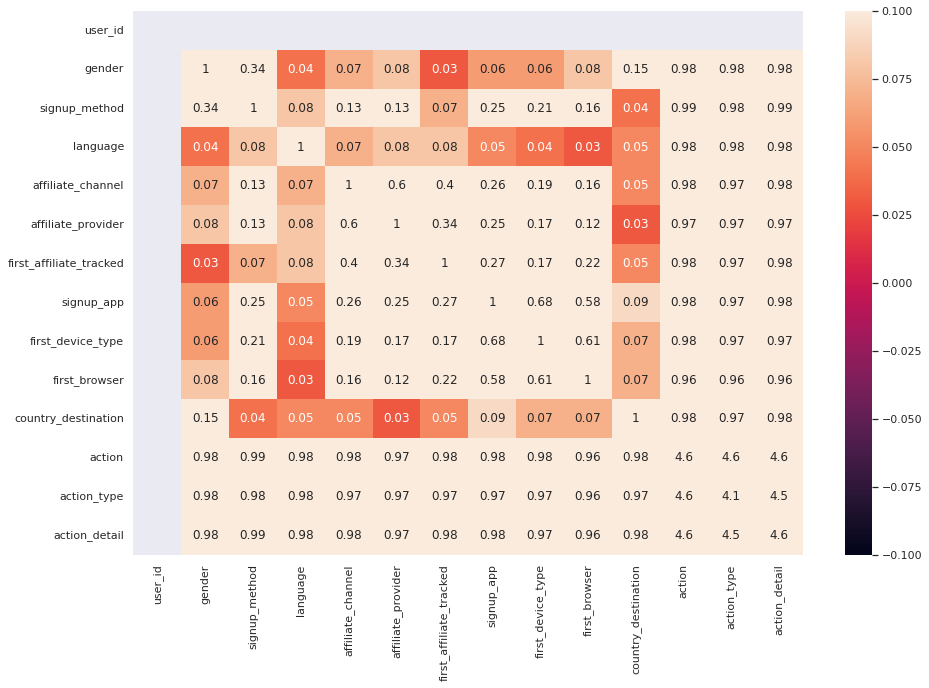

In [73]:
cat_atributes = cat_atributes.sample(20000)

rows = []

for var1 in cat_atributes:
    col = []
    for var2 in cat_atributes:
        cramers = cramer_v(cat_atributes[var1], cat_atributes[var2])
        col.append(round(cramers, 2))
    rows.append(col)

cramers_result = np.array(rows)
df = pd.DataFrame(cramers_result, columns=cat_atributes.columns, index=cat_atributes.columns)

sns.set(rc= {'figure.figsize': (15, 10)})
sns.heatmap(df, annot=True)

In [79]:
df[df > 0.6]


,user_id,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,action,action_type,action_detail
user_id,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
gender,inf,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.98,0.98,0.98
signup_method,inf,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.99,0.98,0.99
language,inf,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.98,0.98,0.98
affiliate_channel,inf,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.98,0.97,0.98
affiliate_provider,inf,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,0.97,0.97,0.97
first_affiliate_tracked,inf,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,0.98,0.97,0.98
signup_app,inf,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.68,NaN,NaN,0.98,0.97,0.98
first_device_type,inf,NaN,NaN,NaN,NaN,NaN,NaN,0.68,1.00,0.61,NaN,0.98,0.97,0.97
first_browser,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61,1.00,NaN,0.96,0.96,0.96


In [85]:
#Correlações
#signup_app x first_device_type
#first_browser X first_device_type

#Aproveitando que essa coluna esta com uma autocorrelação, vou excluir pois tambem ela tem umaaltar dimensionalidade.
df_final = df_final.drop('first_browser', axis=1)


In [87]:
#Separando os Datasets

new_test = df_final[df_final['country_destination'].isna()]
new_train = df_final[~df_final['country_destination'].isna()]


#new_test.to_csv(path_data+ 'final_test.csv', index=False)
#new_train.to_csv(path_data+ 'final_train.csv', index=False)

In [91]:
colums_drop = ['country_destination', 'date_first_booking_days', 'date_account_created_util_booking_days', 'date_first_booking_year', 'date_account_created_util_booking_days',
           'date_first_booking_year', 'date_first_booking_month', 'date_first_booking_week', 'date_first_booking_year_day']

new_test = new_test.drop(colums_drop, axis=1)

In [96]:
print('Number of Rows test: {}'.format(new_test.shape[0]))
print('Number of Columns test: {}'.format(new_test.shape[1]))
print('--------------------------------------------------')
print('Number of Rows train: {}'.format(new_train.shape[0]))
print('Number of Columns train: {}'.format(new_train.shape[1]))
print('------------------------------------------')
print('Number of Rows Join: {}'.format(df_final.shape[0]))
print('Number of Columns Join: {}'.format(df_final.shape[1]))

Number of Rows test: 60978
Number of Columns test: 24
--------------------------------------------------
Number of Rows train: 72718
Number of Columns train: 31
------------------------------------------
Number of Rows Join: 133696
Number of Columns Join: 31


In [97]:
new_test.to_csv(path_data+ 'final_test.csv', index=False)
new_train.to_csv(path_data+ 'final_train.csv', index=False)